# Predict the fraction the borrower will pay back in the case where they default

The total amount they owe is the principle + interest. The fraction paid back is bounded in the range [0, 1], so we use a logit transform so that regression algorithms don't predict values outside this range. The conclusion of this notebook is that there is very little information in the data, and regression is not more accurate than just returning the mean fraction paid back.

In [1]:
%pylab inline

from __future__ import division

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Processing
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import calibration

# Linear regression
from sklearn import linear_model

# Kernel regression
from sklearn import kernel_ridge
from sklearn import svm

# Tree based regression
from sklearn import tree
from sklearn import ensemble

# Neural Network regression
from sklearn import neural_network

# KNN regression
from sklearn import neighbors

import loanutilities as lu

Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp
imp.reload(lu)

<module 'loanutilities' from 'loanutilities.pyc'>

## Load the cleaned data and split it by year

In [3]:
df = pd.read_csv('loan_clean.csv', low_memory=False)

In [4]:
mask_2007 = (df['issue_d']>='2007-01-01') & (df['issue_d']<'2008-01-01')
mask_2008 = (df['issue_d']>='2008-01-01') & (df['issue_d']<'2009-01-01')
mask_2009 = (df['issue_d']>='2009-01-01') & (df['issue_d']<'2010-01-01')
mask_2010 = (df['issue_d']>='2010-01-01') & (df['issue_d']<'2011-01-01')
mask_2011 = (df['issue_d']>='2011-01-01') & (df['issue_d']<'2012-01-01')
mask_2012 = (df['issue_d']>='2012-01-01') & (df['issue_d']<'2013-01-01')
mask_2013 = (df['issue_d']>='2013-01-01') & (df['issue_d']<'2014-01-01')
mask_2014 = (df['issue_d']>='2014-01-01') & (df['issue_d']<'2015-01-01')
mask_2015 = (df['issue_d']>='2015-01-01') & (df['issue_d']<'2016-01-01')

df_2007 = df[mask_2007]
df_2008 = df[mask_2008]
df_2009 = df[mask_2009]
df_2010 = df[mask_2010]
df_2011 = df[mask_2011]
df_2012 = df[mask_2012]
df_2013 = df[mask_2013]
df_2014 = df[mask_2014]
df_2015 = df[mask_2015]

df_list = [df_2007, df_2008, df_2009, df_2010, df_2011, 
           df_2012, df_2013, df_2014, df_2015]

## Functions for extracting the examples and target variable
 - Only include loans that defaulted (frac=1 for loans that didn't default).
 - Transform the fraction paid from the interval $[0, 1]$ to $[-\infty, \infty]$ and back.

In [5]:
def rmse(y_true, y_pred):
    """
    """
    n = len(y_true)
    se = (y_pred - y_true)**2
    rmse = np.sqrt(np.sum(se)/n)
    return rmse

In [6]:
def bounded_to_unbounded(g, epsilon):
    """Transform quantity bounded in range [0, 1] to
    unbounded quantity with slightly adjusted inverse sigmoid.
    This is the slightly compressed logit function.
    """
    g_adj = (1.0-2.0*epsilon)*g + epsilon
    z = np.log(g_adj/(1.0-g_adj))
    return z

def unbounded_to_bounded(z, epsilon):
    """Take unbounded quantity to quantity bounded in range [0, 1].
    Inverts bounded_to_unbounded(g).
    This is the slightly compressed sigmoid function.
    """
    g_adj = 1.0 / (1.0 + np.exp(-z))
    g = (g_adj - epsilon) / (1.0 - 2.0*epsilon)
    return g

In [7]:
def fraction_paid_data_for_default(df, term=3.0, epsilon=0.1):
    """Extract the defaulted loans. 
    Then, get the target variable and features. 
    """
    # Loans that weren't fully paid
    df_default = df[df['bad_loan']==1]

    # Total money owed
    loan_amount = df_default['loan_amnt'].values
    rate = df_default['int_rate'].values / 100
    interest_owed = lu.interest_payments(loan_amount, rate, term)
    total_owed = loan_amount + interest_owed
    
    # Total money payed
    total_paid = (df_default['total_rec_prncp'].values + df_default['total_rec_int'].values)
    
    # Fraction of money payed. Bounded in range [0, 1).
    frac_paid = total_paid / total_owed
    
    # Target variable for regression. Unbounded range.
    y = bounded_to_unbounded(frac_paid, epsilon=epsilon)
    
    # Features
    #X = df_default.drop(['bad_loan', 'issue_d', 'total_rec_prncp', 'total_rec_int'], axis=1)
    
    X = df_default.drop([
        'bad_loan', 'issue_d', 'total_rec_prncp', 'total_rec_int', 
        'addr_state_AK',
       'addr_state_AL', 'addr_state_AR', 'addr_state_AZ', 'addr_state_CA',
       'addr_state_CO', 'addr_state_CT', 'addr_state_DC', 'addr_state_DE',
       'addr_state_FL', 'addr_state_GA', 'addr_state_HI', 'addr_state_IA',
       'addr_state_ID', 'addr_state_IL', 'addr_state_IN', 'addr_state_KS',
       'addr_state_KY', 'addr_state_LA', 'addr_state_MA', 'addr_state_MD',
       'addr_state_ME', 'addr_state_MI', 'addr_state_MN', 'addr_state_MO',
       'addr_state_MS', 'addr_state_MT', 'addr_state_NC', 'addr_state_ND',
       'addr_state_NE', 'addr_state_NH', 'addr_state_NJ', 'addr_state_NM',
       'addr_state_NV', 'addr_state_NY', 'addr_state_OH', 'addr_state_OK',
       'addr_state_OR', 'addr_state_PA', 'addr_state_RI', 'addr_state_SC',
       'addr_state_SD', 'addr_state_TN', 'addr_state_TX', 'addr_state_UT',
       'addr_state_VA', 'addr_state_VT', 'addr_state_WA', 'addr_state_WI',
       'addr_state_WV', 'addr_state_WY'], axis=1)
    
    return frac_paid, y, X.values, X.columns.values

0.0 0.997889563809 0.416616202727 0.446444408178
-2.19722457734 2.17860432467 -0.268428395804 -0.197033279883


(0, 1)

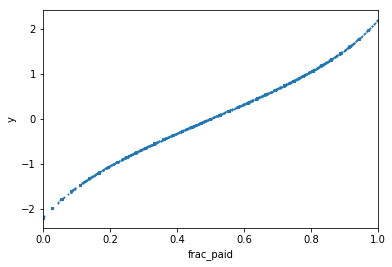

In [8]:
frac_paid, y, X, col_names = fraction_paid_data_for_default(df_2012, epsilon=0.1)
print frac_paid.min(), frac_paid.max(), np.median(frac_paid), frac_paid.mean()
print y.min(), y.max(), np.median(y), y.mean()

fig, axes = plt.subplots()
axes.scatter(frac_paid, y, s=1)
axes.set_xlabel('frac_paid')
axes.set_ylabel('y')
axes.set_xlim(0, 1)

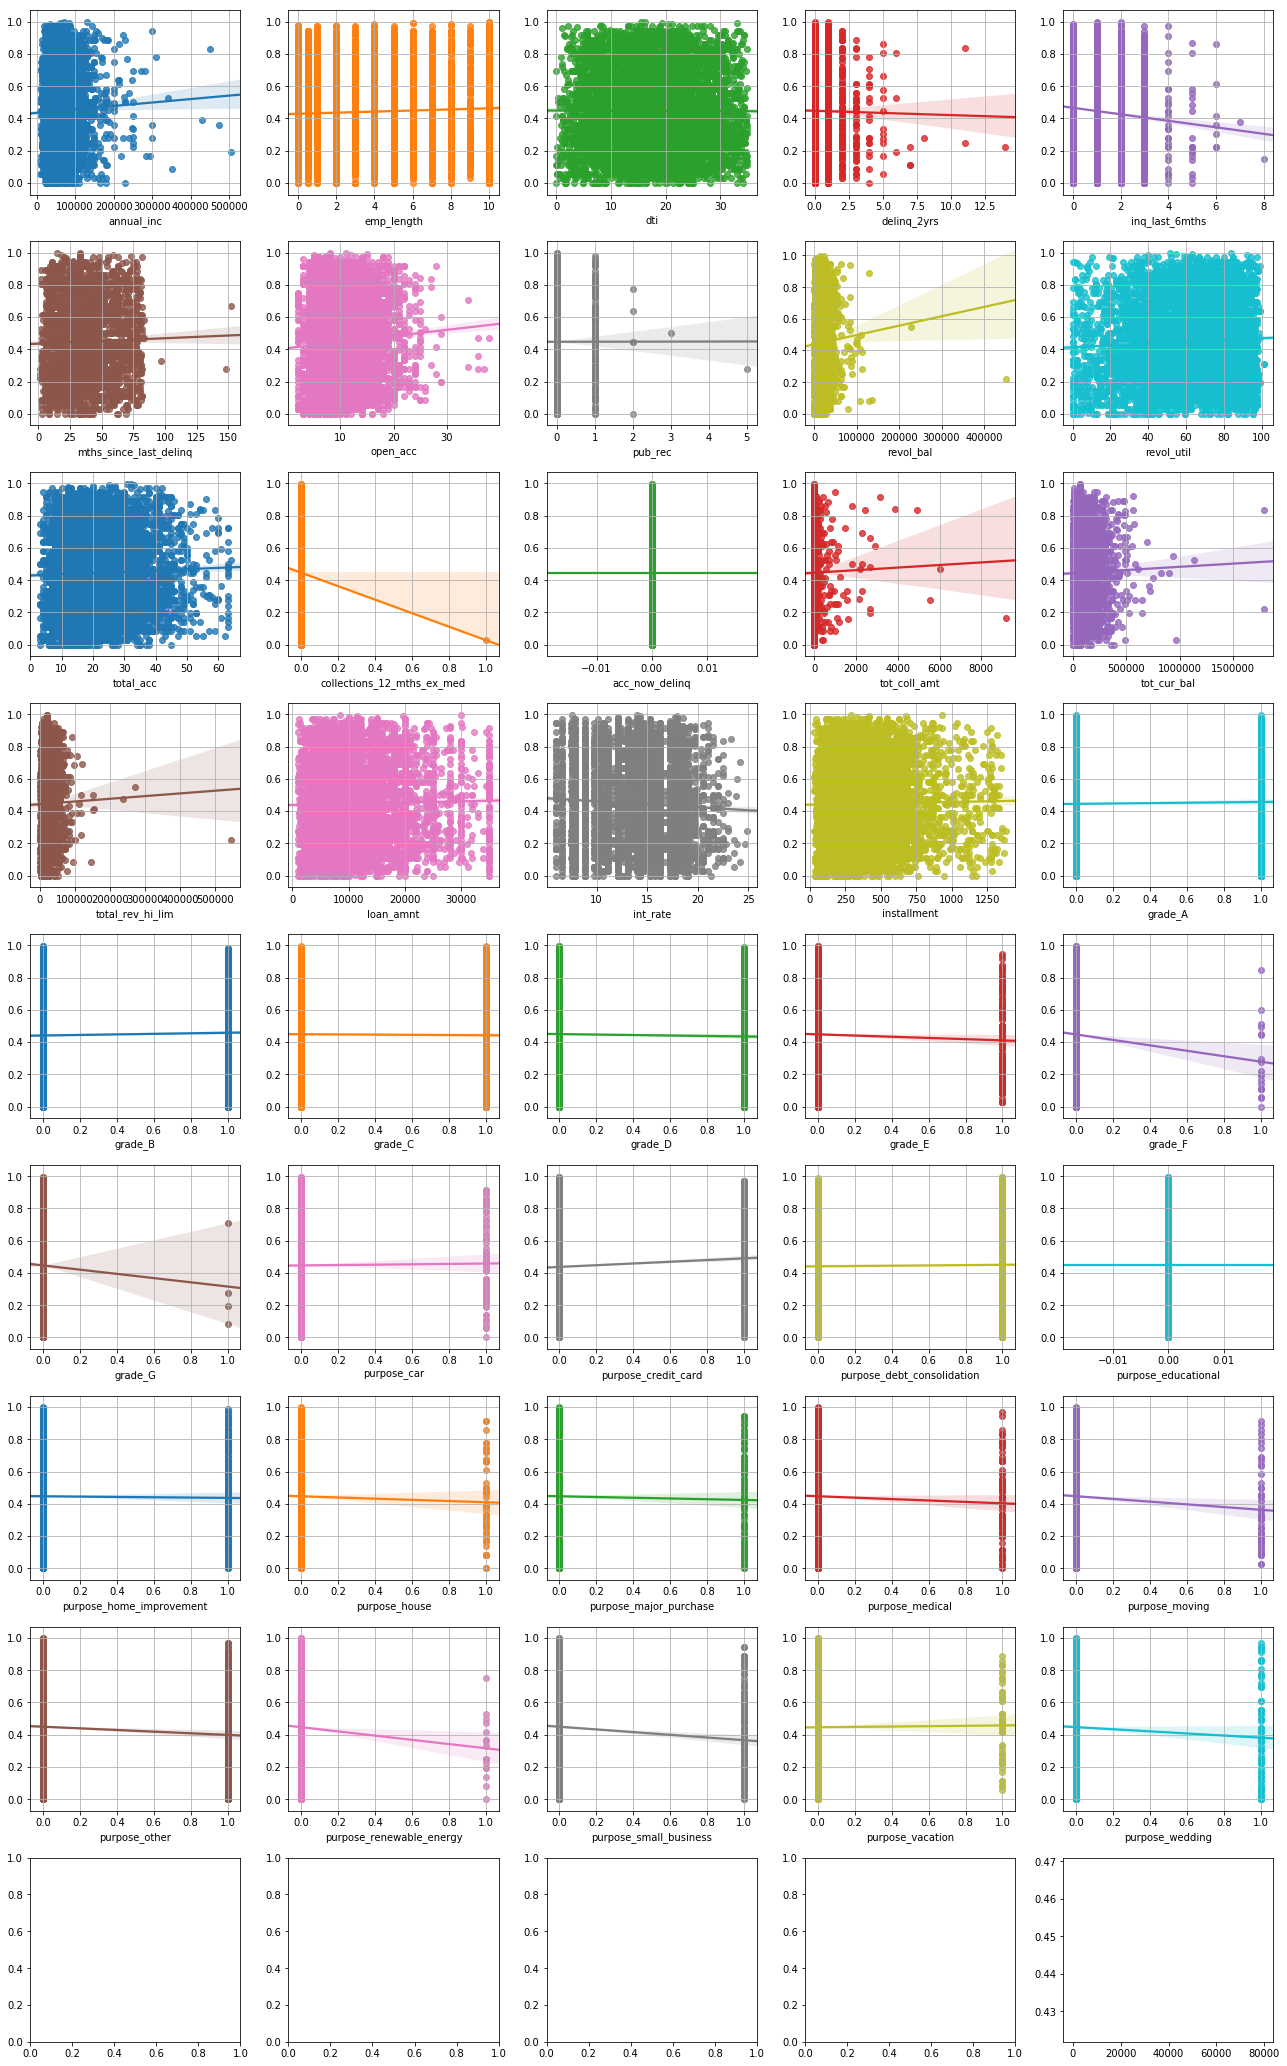

In [9]:
n = 40
ncol = 5
nrow = n//ncol + 1

fig, ax = plt.subplots(nrow, ncol, figsize=(18, 3.2*nrow))

for i in range(n):
    column = col_names[i]
    axes = ax[i//ncol, i%ncol]
    sns.regplot(x=X[:, i], y=frac_paid, x_jitter=False, ax=axes)
    #sns.regplot(x=X[:, i], y=y, x_jitter=False, ax=axes)
    axes.set_xlabel(column)
    axes.grid(which='both')
    
fig.tight_layout()

## Train-test set split and feature scaling

In [10]:
# Regression among the defaulted loans only
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

# Train-test split for fraction_paid
frac_paid_train = unbounded_to_bounded(y_train, epsilon=0.1)
frac_paid_test = unbounded_to_bounded(y_test, epsilon=0.1)

# Create feature scaling object (mean/standard-deviation scaling).
# Only use the training set for determining the scaling. 
# Otherwise, you indirectly use information about the validation set.
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Perform feature scaling
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Try a large number of regression algorithms and tune their hyperparameters

### Return the mean (f(x)=mean)

In [11]:
y_pred_train = np.mean(y_train)*np.ones(len(y_train))
y_pred_test = np.mean(y_train)*np.ones(len(y_test))

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

0.902214517581 0.907906492396
0.245858375049 0.247873762444


In [13]:
np.mean(frac_paid_train), np.mean(frac_paid_test)

(0.44461031392567602, 0.45377921624190642)

### Linear regression

In [33]:
alphas = np.logspace(-6, 6, 25)
print alphas
reg = linear_model.RidgeCV(alphas=alphas, cv=10)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

[  1.00000000e-06   3.16227766e-06   1.00000000e-05   3.16227766e-05
   1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00   3.16227766e+00   1.00000000e+01   3.16227766e+01
   1.00000000e+02   3.16227766e+02   1.00000000e+03   3.16227766e+03
   1.00000000e+04   3.16227766e+04   1.00000000e+05   3.16227766e+05
   1.00000000e+06]
0.882998402715 0.898985461134
0.24067505358 0.245861352712


In [34]:
reg.alpha_, reg.fit_intercept, reg.intercept_, y_train.mean()

(1000.0, True, -0.20368454335409744, -0.20368454335409555)

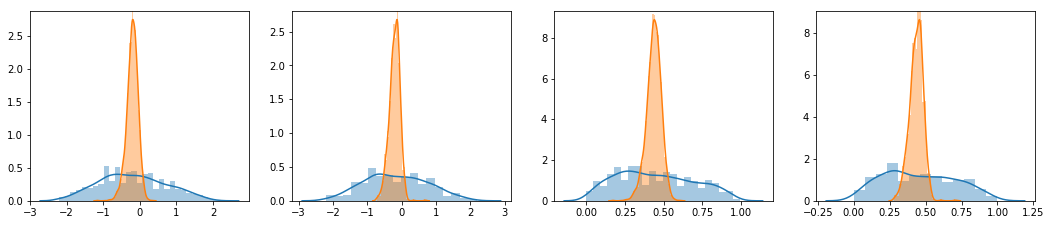

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 3.5))

sns.distplot(y_train, ax=ax1)
sns.distplot(y_pred_train, ax=ax1)

sns.distplot(y_test, ax=ax2)
sns.distplot(y_pred_test, ax=ax2)

sns.distplot(frac_paid_train, ax=ax3)
sns.distplot(frac_paid_pred_train, ax=ax3)

sns.distplot(frac_paid_test, ax=ax4)
sns.distplot(frac_paid_pred_test, ax=ax4)

### KNN regression

In [36]:
for n_neighbors in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]:
    reg = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, p=2)
    reg.fit(X_train, y_train)

    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)

    frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
    frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)
    print ''
    print n_neighbors, rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
    print n_neighbors, rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)


1 0.0 1.2753820533
1 0.0 0.347309142976

2 0.6249166739 1.08633669405
2 0.170684104918 0.301483641536

5 0.8012382373 0.977543511745
5 0.218916256099 0.271169001815

10 0.84651449709 0.934769985174
10 0.23104619359 0.257777895599

20 0.862544439773 0.911849735905
20 0.235054206593 0.250365597298

50 0.8814730532 0.903356000358
50 0.240112297404 0.24713264063

100 0.886433305658 0.905573690999
100 0.241279327492 0.247466710202

200 0.890734540542 0.903807226832
200 0.242370914355 0.246637439598

500 0.894347748666 0.903147472037
500 0.243273202164 0.246225171016

1000 0.897073524868 0.904229614091
1000 0.244017792395 0.246496560094

2000 0.90004377938 0.905528994455
2000 0.244845135138 0.246796159074


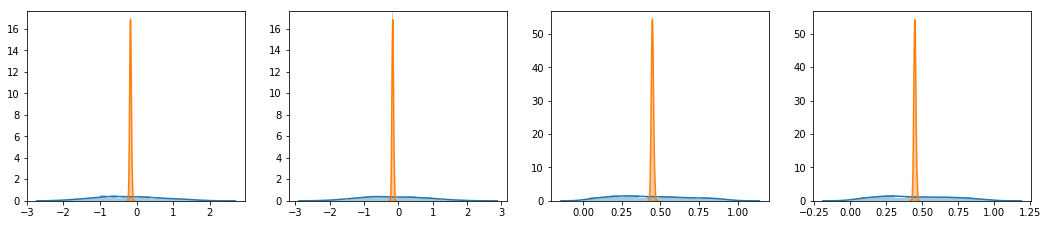

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 3.5))

sns.distplot(y_train, ax=ax1)
sns.distplot(y_pred_train, ax=ax1)

sns.distplot(y_test, ax=ax2)
sns.distplot(y_pred_test, ax=ax2)

sns.distplot(frac_paid_train, ax=ax3)
sns.distplot(frac_paid_pred_train, ax=ax3)

sns.distplot(frac_paid_test, ax=ax4)
sns.distplot(frac_paid_pred_test, ax=ax4)

### SVM regression

In [42]:
reg = svm.SVR(C=10, kernel='rbf', gamma=0.01)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

0.776489075096 0.950702078131
0.21157850128 0.262700826248


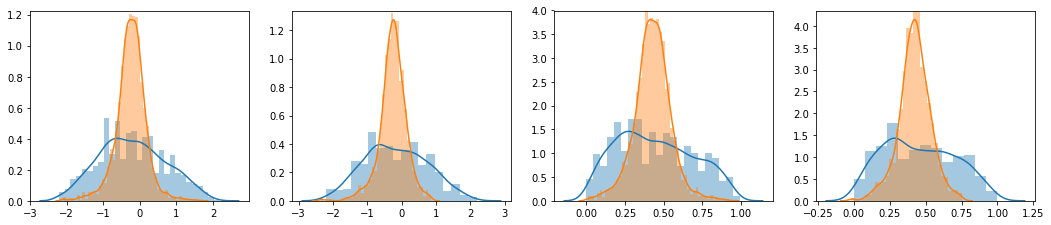

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 3.5))

sns.distplot(y_train, ax=ax1)
sns.distplot(y_pred_train, ax=ax1)

sns.distplot(y_test, ax=ax2)
sns.distplot(y_pred_test, ax=ax2)

sns.distplot(frac_paid_train, ax=ax3)
sns.distplot(frac_paid_pred_train, ax=ax3)

sns.distplot(frac_paid_test, ax=ax4)
sns.distplot(frac_paid_pred_test, ax=ax4)

In [44]:
estimator = svm.SVR()

# Search over these parameters
Cs = np.logspace(-3, 3, 10)
gammas = np.logspace(-4, 3, 11)
parameters = {'kernel':['rbf'], 'C':Cs, 'gamma':gammas}

# Set up the grid
# n_jobs=-1 runs jobs in parallel on all available cores
grid = model_selection.GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=3, 
                                    n_jobs=-1, verbose=1)

# Fit to data for each of the hyperparameter combinations.
# This passes the .fit() method to model_selection.cross_val_score() which then passes it to svm.SVR()
grid.fit(X_train, y_train)

Fitting 3 folds for each of 110 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'C': array([  1.00000e-03,   4.64159e-03,   2.15443e-02,   1.00000e-01,
         4.64159e-01,   2.15443e+00,   1.00000e+01,   4.64159e+01,
         2.15443e+02,   1.00000e+03]), 'gamma': array([  1.00000e-04,   5.01187e-04,   2.51189e-03,   1.25893e-02,
         6.30957e-02,   3.16228e-01,   1.58489e+00,   7.94328e+00,
         3.98107e+01,   1.99526e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [46]:
# Best estimator
# When refit=True (by default), best_estimator_ is refit on all the data (not just the train split).
reg = grid.best_estimator_
print reg

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

SVR(C=0.10000000000000001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0025118864315095794, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
0.884784561813 0.900983522714
0.24147012429 0.246720549106


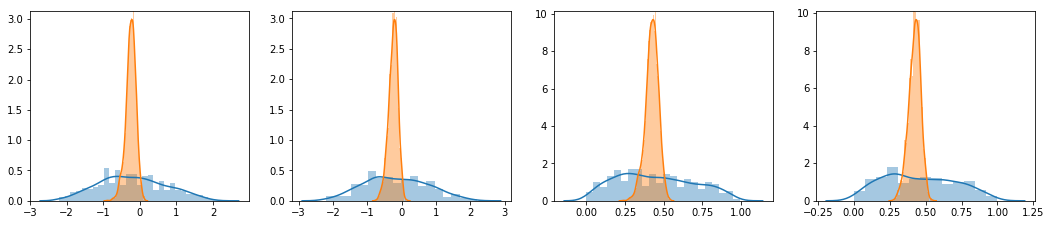

In [47]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 3.5))

sns.distplot(y_train, ax=ax1)
sns.distplot(y_pred_train, ax=ax1)

sns.distplot(y_test, ax=ax2)
sns.distplot(y_pred_test, ax=ax2)

sns.distplot(frac_paid_train, ax=ax3)
sns.distplot(frac_paid_pred_train, ax=ax3)

sns.distplot(frac_paid_test, ax=ax4)
sns.distplot(frac_paid_pred_test, ax=ax4)

### Random Forest regression

In [52]:
n_est=100
max_depth = 10
min_samples_leaf = 10
min_samples_split = 2
reg = RandomForestRegressor(
    n_estimators=n_est, max_depth=max_depth, 
    min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
    max_features='sqrt', 
    n_jobs=-1, random_state=1)

reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

0.829264960574 0.897971370492
0.224220264262 0.245380095096


In [53]:
estimator = RandomForestRegressor()

# Search over these parameters
n_estimators = [50, 100, 200]
max_depth = [5, 8, 15, 25, 30]
min_samples_leaf = [1, 2, 5, 10, 15, 100, 200, 500]
min_samples_split = [2, 5]
parameters = {
    'max_features':['sqrt'], 
    'n_estimators':n_estimators, 'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf, 'min_samples_split':min_samples_split}

# Set up the grid
grid = model_selection.GridSearchCV(
    estimator, parameters, scoring='neg_mean_squared_error', 
    cv=3, n_jobs=-1, verbose=1)

# Fit for each set of hyperparameters
grid.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt'], 'n_estimators': [50, 100, 200], 'min_samples_split': [2, 5], 'max_depth': [5, 8, 15, 25, 30], 'min_samples_leaf': [1, 2, 5, 10, 15, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [54]:
# Best estimator
# When refit=True (by default), best_estimator_ is refit on all the data (not just the train split).
reg = grid.best_estimator_
print reg

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

frac_paid_pred_train = unbounded_to_bounded(y_pred_train, epsilon=0.1)
frac_paid_pred_test = unbounded_to_bounded(y_pred_test, epsilon=0.1)

print rmse(y_train, y_pred_train), rmse(y_test, y_pred_test)
print rmse(frac_paid_train, frac_paid_pred_train), rmse(frac_paid_test, frac_paid_pred_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=15,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
0.815243738434 0.897090795368
0.219786643658 0.245156607881


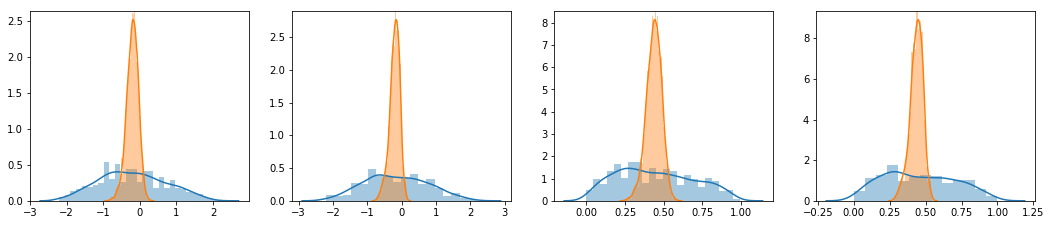

In [55]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 3.5))

sns.distplot(y_train, ax=ax1)
sns.distplot(y_pred_train, ax=ax1)

sns.distplot(y_test, ax=ax2)
sns.distplot(y_pred_test, ax=ax2)

sns.distplot(frac_paid_train, ax=ax3)
sns.distplot(frac_paid_pred_train, ax=ax3)

sns.distplot(frac_paid_test, ax=ax4)
sns.distplot(frac_paid_pred_test, ax=ax4)